The travelling salesman problem is a famous problem in computer science. It was stated by William Rowan Hamilton, who is most famous for his contributions to optics, mechanics and algebra, notably for the invention of quaternions.



In [3]:
import matplotlib.pyplot as ply
%matplotlib inline

import networkx as nx
import numpy as np

from qiskit_aqua.translators.ising import tsp
from qiskit_aqua.input import EnergyInput
from qiskit_aqua import run_algorithm
from qiskit_qcgpu_provider import QCGPUProvider

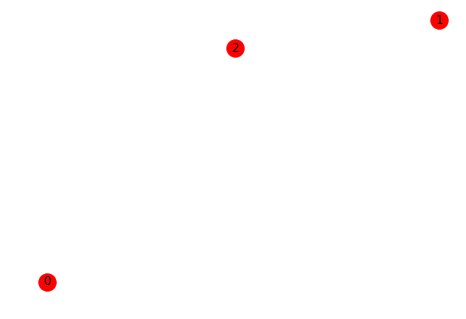

In [4]:
locations = 3

problem = tsp.random_tsp(locations)
positions = {k: v for k, v in enumerate(problem.coord)}

G = nx.Graph()
G.add_nodes_from(np.arange(0, locations, 1))
nx.draw(G, with_labels=True, pos=positions)

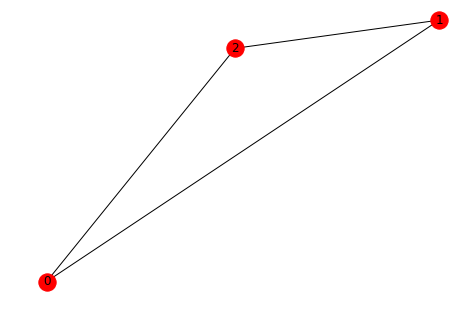

In [5]:
best_distance, best_order = brute_force(problem.w, problem.dim)
draw(G, best_order, positions)

# Solving Using The Variational Quantum Eigensolver

In [6]:
operator, offset = tsp.get_tsp_qubitops(problem)
algorithm_input = EnergyInput(operator)

algorithm_parameters = {
    'problem': { 'name': 'ising', 'random_seed': 23 },
    'algorithm': { 'name': 'VQE', 'operator_mode': 'matrix' },
    'optimizer': { 'name': 'SPSA', 'max_trials':100 },
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}

In [7]:
backend = QCGPUProvider().get_backend('statevector_simulator')
%time result_qiskit = run_algorithm(algorithm_parameters, algorithm_input)
%time result = run_algorithm(algorithm_parameters, algorithm_input, backend=backend)


CPU times: user 32.1 s, sys: 127 ms, total: 32.3 s
Wall time: 36.8 s
CPU times: user 22.9 s, sys: 241 ms, total: 23.1 s
Wall time: 23.1 s


Look at that! It completed it 13 seconds quicker, just by using the GPU!

feasible: True
solution: [2, 1, 0]
solution objective: 203.0


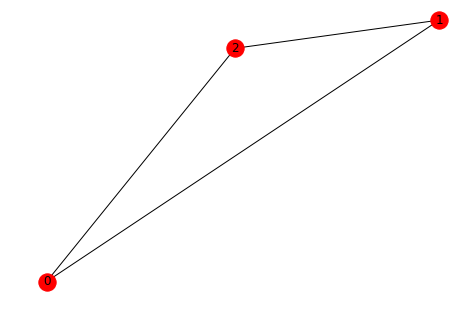

In [8]:
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, problem.w))
draw(G, z, positions)

In [1]:
# Utitlity Functions
def draw(G, order, positions):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    nx.draw(G2, pos=positions, with_labels=True)
    
# Classically solve the problem using a brute-force method
from itertools import permutations

def brute_force(weights, N):
    a = list(permutations(range(1, N)))
    best_distance = None
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance += weights[j, pre_j]
            pre_j = j
        distance += weights[pre_j, 0]
        order = (0,) + i
        if best_distance is None or distance < best_distance:
            best_order = order
            best_distance = distance
            
    return best_distance, best_order

In [2]:
import warnings
warnings.filterwarnings('ignore')